In [ ]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import combinations
from tqdm import tqdm


sns.set_style("darkgrid")
%matplotlib inline

SEED = 86
rng = np.random.default_rng(SEED)

## Часть первая, с блекджеком и стратегиями

1) Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.
Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [ ]:
env = gym.make("Blackjack-v0", natural=True)

* env.reset() returns an observation of a 3-tuple of: the players current sum, the dealer's one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1).
* env.step(action) returns observation(as above), reward, done and {}.

In [ ]:
def pi_simple(obs):
  '''returns action
  action = 1 corresponds to hit
  action = 0 corresponds to stand
  '''
  return obs[0] < 19

def run_policy(policy, n_iter):
  rewards = []
  for it in range(n_iter):
    obs = env.reset()
    done = False
    while not done:
      action = policy(obs)
      obs, reward, done, _ = env.step(action)
      if done:
        rewards.append(reward)
  return np.mean(rewards), np.std(rewards)

In [ ]:
rewards_mean, rewards_std = run_policy(pi_simple, 150_000)
print(f"Mean reward:{rewards_mean}, std of rewards: {rewards_std}")

Mean reward:-0.17866, std of rewards: 0.9719193747768725


2) Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.


Below I try MC on-policy control and search for the best parameters: $\varepsilon$ defining the randomness in the policy and the dicsount factor $\gamma$.  

In [ ]:
def get_trajectory(env, pi, eps=0.1):
    obs = env.reset()
    next_action = pi[obs] if rng.random() > eps else rng.choice(env.action_space.n)
    states, actions, rewards = [obs], [next_action], [0]
    while True:
        obs, reward, done, _ = env.step(next_action)
        states.append(obs)
        next_action = pi[obs] if rng.random() > eps else rng.choice(env.action_space.n)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards


def update(R, Q, pi, states, actions, rewards, gamma=1.0):
    state_first_visit = defaultdict(lambda: -1)
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
    G = 0
    if state_first_visit[states[-1]] == len(states) - 1:

      R[states[-1]][actions[-1]] += 1
      n = R[states[-1]][actions[-1]]
      Q[states[-1]][actions[-1]] *= (n - 1) / n 

    for t in range(len(states)-2, -1, -1):
        G = G * gamma + rewards[t + 1]
        if state_first_visit[states[t]] == t:
          R[states[t]][actions[t]] += 1
          n = R[states[t]][actions[t]]
          Q[states[t]][actions[t]] = (n - 1) / n * Q[states[t]][actions[t]] + G / n
          pi[states[t]] = np.nanargmax(Q[states[t]])
    return R, Q, pi


def compute_policy(pi, Q):
  for state in Q:
      pi[state] = np.nanargmax(Q[state])
  return pi


def initialize_Q(env, random=True):
  if random:
    Q = defaultdict(lambda: rng.random(env.action_space.n))
  else:
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
  for player in range(32):
    for dealer in range(11):
      for ace in range(2):
        if player > 21:
          Q[(player, dealer, ace)] = -1 * np.ones(env.action_space.n)
        elif player == 21:
          Q[(player, dealer, ace)] = np.ones(env.action_space.n)

  return Q


def run_policy(env, policy, n_iter):
  rewards = []
  for it in range(n_iter):
    obs = env.reset()
    done = False
    while not done:
      action = policy[obs]
      obs, reward, done, _ = env.step(action)
      if done:
        rewards.append(reward)
  return np.mean(rewards), np.std(rewards)

In [ ]:
def train_MC(env, total_episodes=1_000_000, policy_run_episodes=150_000, 
             eval_every_n_eps=1000, print_every_n_eps=2000, initial_run_episodes=1000, 
             eps=.3, gamma=.5, random_Q=True):
  pi = defaultdict(int)
  Q = initialize_Q(env, random=random_Q)
  pi = compute_policy(pi, Q)
  
  R = defaultdict(lambda: [0 for _ in range(env.action_space.n)])
  for _ in range(initial_run_episodes):
    states, actions, rewards = get_trajectory(env, pi, eps=eps)
    R, Q, pi = update(R, Q, pi, states, actions, rewards, gamma)

  rewards_for_plot = []
  print("#########Training policy#########")
  for ep in tqdm(range(total_episodes), position=0, leave=True):
    states, actions, rewards = get_trajectory(env, pi, eps=eps)
    R, Q, pi = update(R, Q, pi, states, actions, rewards, gamma)

    if (ep + 1) % eval_every_n_eps == 0 :
      mean_rewards, std_rewards = run_policy(env, pi, policy_run_episodes)
      if (ep + 1) % print_every_n_eps == 0:
          print(f"|| Mean reward: {mean_rewards} ")
      rewards_for_plot.append([mean_rewards, std_rewards, ep])

  return {
      "policy": pi, 
      "rewards": rewards_for_plot
          }

Searching for the best parameters...

In [ ]:
runs = {}
env = gym.make("Blackjack-v0", natural=True)

In [ ]:
for eps in [0.1, 0.3, 0.5]:
  for gamma in [0.5, 0.6, 0.7]:
    print(f"eps={eps}, gamma={gamma}")
    result = train_MC(env, eps=eps, gamma=gamma, 
                      total_episodes=1_000_000, 
                      eval_every_n_eps=100_000,
                      print_every_n_eps=200_000)
    runs[f"{eps}, {gamma}"] = result

eps=0.1, gamma=0.5
#########Training policy#########


 20%|██        | 201325/1000000 [00:40<28:10, 472.53it/s]

|| Mean reward: -0.028013333333333335 


 40%|████      | 401316/1000000 [01:21<20:43, 481.60it/s]

|| Mean reward: -0.02502 


 60%|██████    | 600651/1000000 [02:01<19:46, 336.67it/s] 

|| Mean reward: -0.030356666666666667 


 80%|████████  | 800988/1000000 [02:42<07:41, 431.38it/s]

|| Mean reward: -0.027546666666666667 


100%|██████████| 1000000/1000000 [03:22<00:00, 4938.85it/s]


|| Mean reward: -0.026153333333333334 
eps=0.1, gamma=0.6
#########Training policy#########


 20%|██        | 201573/1000000 [00:40<27:27, 484.55it/s]

|| Mean reward: -0.03308 


 40%|████      | 400803/1000000 [01:21<22:04, 452.28it/s]

|| Mean reward: -0.02855 


 60%|██████    | 601423/1000000 [02:01<14:16, 465.16it/s]

|| Mean reward: -0.02785 


 80%|████████  | 801361/1000000 [02:42<07:10, 461.01it/s]

|| Mean reward: -0.029 


100%|██████████| 1000000/1000000 [03:23<00:00, 4919.99it/s]


|| Mean reward: -0.027823333333333332 
eps=0.1, gamma=0.7
#########Training policy#########


 20%|██        | 201540/1000000 [00:41<20:59, 633.83it/s]

|| Mean reward: -0.029356666666666666 


 40%|████      | 401313/1000000 [01:21<20:56, 476.52it/s]

|| Mean reward: -0.02922 


 60%|██████    | 601449/1000000 [02:03<14:02, 472.98it/s]

|| Mean reward: -0.024613333333333334 


 80%|████████  | 801078/1000000 [02:43<07:10, 462.59it/s]

|| Mean reward: -0.02708 


100%|██████████| 1000000/1000000 [03:24<00:00, 4893.44it/s]


|| Mean reward: -0.02224 
eps=0.3, gamma=0.5
#########Training policy#########


 20%|██        | 201330/1000000 [00:40<27:44, 479.95it/s]

|| Mean reward: -0.03255 


 40%|████      | 400876/1000000 [01:21<21:04, 473.79it/s]

|| Mean reward: -0.03131333333333333 


 60%|██████    | 601304/1000000 [02:02<14:21, 463.04it/s]

|| Mean reward: -0.02851 


 80%|████████  | 800682/1000000 [02:43<07:39, 433.77it/s]

|| Mean reward: -0.029166666666666667 


100%|██████████| 1000000/1000000 [03:24<00:00, 4901.39it/s]


|| Mean reward: -0.0285 
eps=0.3, gamma=0.6
#########Training policy#########


 20%|██        | 201259/1000000 [00:40<28:51, 461.31it/s]

|| Mean reward: -0.029683333333333332 


 40%|████      | 400840/1000000 [01:21<20:53, 478.00it/s]

|| Mean reward: -0.026386666666666666 


 60%|██████    | 600851/1000000 [02:01<14:13, 467.75it/s]

|| Mean reward: -0.030106666666666667 


 80%|████████  | 801057/1000000 [02:42<07:06, 466.97it/s]

|| Mean reward: -0.029296666666666665 


100%|██████████| 1000000/1000000 [03:23<00:00, 4905.61it/s]


|| Mean reward: -0.03067 
eps=0.3, gamma=0.7
#########Training policy#########


 20%|██        | 201429/1000000 [00:41<28:01, 474.94it/s]

|| Mean reward: -0.03301333333333333 


 40%|████      | 401429/1000000 [01:21<21:10, 471.00it/s]

|| Mean reward: -0.02826 


 60%|██████    | 601183/1000000 [02:02<14:04, 472.23it/s]

|| Mean reward: -0.033863333333333336 


 80%|████████  | 801498/1000000 [02:43<07:09, 462.01it/s]

|| Mean reward: -0.030966666666666667 


100%|██████████| 1000000/1000000 [03:24<00:00, 4894.77it/s]


|| Mean reward: -0.02624 
eps=0.5, gamma=0.5
#########Training policy#########


 20%|██        | 200905/1000000 [00:41<28:11, 472.48it/s]

|| Mean reward: -0.03700666666666667 


 40%|████      | 401164/1000000 [01:22<22:06, 451.54it/s]

|| Mean reward: -0.029286666666666666 


 60%|██████    | 601092/1000000 [02:04<14:15, 466.08it/s]

|| Mean reward: -0.03753666666666667 


 80%|████████  | 801413/1000000 [02:45<07:16, 454.86it/s]

|| Mean reward: -0.03405333333333333 


100%|██████████| 1000000/1000000 [03:26<00:00, 4843.91it/s]


|| Mean reward: -0.03095 
eps=0.5, gamma=0.6
#########Training policy#########


 20%|██        | 201394/1000000 [00:41<29:58, 444.11it/s]

|| Mean reward: -0.03196333333333334 


 40%|████      | 400973/1000000 [01:23<21:55, 455.19it/s]

|| Mean reward: -0.03211666666666667 


 60%|██████    | 600962/1000000 [02:04<14:47, 449.70it/s]

|| Mean reward: -0.03417 


 80%|████████  | 800591/1000000 [02:45<07:46, 427.14it/s]

|| Mean reward: -0.03092 


100%|██████████| 1000000/1000000 [03:26<00:00, 4837.91it/s]


|| Mean reward: -0.033093333333333336 
eps=0.5, gamma=0.7
#########Training policy#########


 20%|██        | 200790/1000000 [00:41<28:37, 465.38it/s]

|| Mean reward: -0.032396666666666664 


 40%|████      | 401393/1000000 [01:22<21:43, 459.40it/s]

|| Mean reward: -0.02943 


 60%|██████    | 601319/1000000 [02:03<14:25, 460.75it/s]

|| Mean reward: -0.02972 


 80%|████████  | 800862/1000000 [02:45<07:15, 457.63it/s]

|| Mean reward: -0.031166666666666665 


100%|██████████| 1000000/1000000 [03:25<00:00, 4854.86it/s]

|| Mean reward: -0.035423333333333334 


3) Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

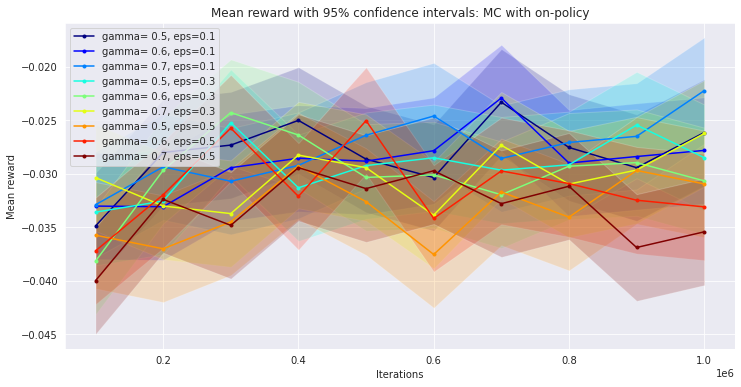

In [ ]:
fg, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, len(runs))])
normalizer = np.sqrt(150_000)

for key, run in runs.items():
  label_eps, label_gamma = key.split(",")
  ax.plot([r[-1] + 1 for r in run["rewards"]], 
          [r[0] for r in run["rewards"]],
          marker='.', label=f"gamma={label_gamma}, eps={label_eps}")
  ax.fill_between([r[-1] + 1 for r in run["rewards"]], 
                  [r[0] + 1.96 * r[1] / normalizer for r in run["rewards"]], 
                  [r[0] - 1.96 * r[1] / normalizer for r in run["rewards"]],
                  alpha=.2)
  
ax.set_title("Mean reward with 95% confidence intervals: MC with on-policy")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean reward")

ax.legend(loc="best")
fg.show()

In [ ]:
env.close()

## Часть вторая, удвоенная
Итак, у игрока появляется дополнительное действие:
➢ double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [ ]:
from gym.envs.toy_text.blackjack import (BlackjackEnv, cmp as blackjack_cmp,
                                         draw_card, draw_hand, is_natural,
                                         is_bust, score, sum_hand, usable_ace)

from gym import spaces
from gym.utils import seeding


class BlackjackEnvDouble(BlackjackEnv):
    def __init__(self, natural, seed):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), 
             spaces.Discrete(11), 
             spaces.Discrete(2))
        )
        self.seed(seed)
        self.natural = natural
        self.reset()
       

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2: # double: add card to players hand and double reward/loss
            self.player.append(draw_card(self.np_random))
            done = True
            if is_bust(self.player):
                reward = -2.0
            else:
              while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
              reward = 2 * blackjack_cmp(score(self.player), score(self.dealer))
              if (self.natural 
                  and is_natural(self.player) 
                  and reward == 2
                  ):
                reward = 3    
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = blackjack_cmp(score(self.player), score(self.dealer))
            if (self.natural
                and is_natural(self.player)
                and reward == 1.0
                ):
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

A slightly different initialization, taking into account a doubling action.

In [ ]:
def initialize_Q(env, random=True):
  if random:
    Q = defaultdict(lambda: rng.random(env.action_space.n))
  else:
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
  for player in range(32):
    for dealer in range(11):
      for ace in range(2):
        if player > 21:
          Q[(player, dealer, ace)] = -1 * np.ones(env.action_space.n)
          Q[(player, dealer, ace)][2] = -2
        elif player == 21:
          Q[(player, dealer, ace)] = np.ones(env.action_space.n)
          Q[(player, dealer, ace)][2] = 2

  return Q

In [ ]:
def plot_runs(runs):
  fg, ax = plt.subplots(1, 1, figsize=(12, 6))
  ax.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, len(runs))])
  normalizer = np.sqrt(150_000)

  for key, run in runs.items():
    data = key.split(",")
    if len(data) == 4:
      init = "zero"
    else:
      init = "rnd"
    label_eps, label_gamma = data[1], data[2]
    ax.plot([r[-1] + 1 for r in run["rewards"]], 
            [r[0] for r in run["rewards"]],
            marker='.', label=f"gamma={label_gamma}, eps={label_eps}, init={init}")
    ax.fill_between([r[-1] + 1 for r in run["rewards"]], 
                    [r[0] + 1.96 * r[1] / normalizer for r in run["rewards"]], 
                    [r[0] - 1.96 * r[1] / normalizer for r in run["rewards"]],
                    alpha=.2)
    
  ax.set_title("Mean reward with 95% confidence intervals: on-policy MC")
  ax.set_xlabel("Iterations")
  ax.set_ylabel("Mean reward")

  ax.legend(loc="lower right")
  fg.show()

Doing a few runs again with different parameters.

In [ ]:
runs2 = {}
seed = 1
env = BlackjackEnvDouble(natural=True, seed=seed)

In [ ]:
eps = .1
gamma = .7
result = train_MC(env, eps=eps, gamma=gamma, total_episodes=2_000_000, 
                  print_every_n_eps=200_000, eval_every_n_eps=100_000)
runs2[f"{seed}, {eps}, {gamma}"] = result

#########Training policy#########


 10%|█         | 201505/2000000 [00:40<1:02:20, 480.84it/s]

|| Mean reward: -0.021843333333333333 


 20%|██        | 401375/2000000 [01:20<55:31, 479.85it/s]  

|| Mean reward: -0.01943 


 30%|███       | 601283/2000000 [02:01<48:17, 482.74it/s]  

|| Mean reward: -0.016826666666666667 


 40%|████      | 801219/2000000 [02:42<43:25, 460.18it/s]

|| Mean reward: -0.016453333333333334 


 50%|█████     | 1001059/2000000 [03:22<35:43, 465.98it/s]

|| Mean reward: -0.009523333333333333 


 60%|██████    | 1201183/2000000 [04:02<27:28, 484.69it/s]

|| Mean reward: -0.01508 


 70%|███████   | 1401379/2000000 [04:43<20:38, 483.44it/s]

|| Mean reward: -0.019236666666666666 


 80%|████████  | 1601479/2000000 [05:23<13:36, 488.20it/s]

|| Mean reward: -0.016736666666666667 


 90%|█████████ | 1801627/2000000 [06:04<06:57, 475.50it/s]

|| Mean reward: -0.009753333333333333 


100%|██████████| 2000000/2000000 [06:44<00:00, 4948.60it/s]

|| Mean reward: -0.014363333333333334 


In [ ]:
eps = .3
gamma = .7
result = train_MC(env, eps=eps, gamma=gamma, total_episodes=2_000_000, 
                  print_every_n_eps=200_000, eval_every_n_eps=100_000)
runs2[f"{seed}, {eps}, {gamma}"] = result

#########Training policy#########


 10%|█         | 201571/2000000 [00:40<1:03:15, 473.85it/s]

|| Mean reward: -0.02217 


 20%|██        | 401225/2000000 [01:20<54:22, 490.10it/s]  

|| Mean reward: -0.013196666666666667 


 30%|███       | 600739/2000000 [02:00<49:52, 467.54it/s]  

|| Mean reward: -0.01917 


 40%|████      | 801212/2000000 [02:40<41:34, 480.63it/s]

|| Mean reward: -0.028273333333333334 


 50%|█████     | 1000832/2000000 [03:20<36:54, 451.20it/s]

|| Mean reward: -0.023386666666666667 


 60%|██████    | 1201625/2000000 [03:59<26:17, 506.25it/s]

|| Mean reward: -0.02208 


 70%|███████   | 1400916/2000000 [04:39<20:43, 481.61it/s]

|| Mean reward: -0.018816666666666666 


 80%|████████  | 1600852/2000000 [05:19<14:20, 463.85it/s]

|| Mean reward: -0.0248 


 90%|█████████ | 1800998/2000000 [05:59<06:45, 490.85it/s]

|| Mean reward: -0.029423333333333333 


100%|██████████| 2000000/2000000 [06:39<00:00, 5007.73it/s]

|| Mean reward: -0.022993333333333334 


In [ ]:
eps = .1
gamma = .5
result = train_MC(env, eps=eps, gamma=gamma, total_episodes=2_000_000, 
                  print_every_n_eps=200_000, eval_every_n_eps=100_000)
runs2[f"{seed}, {eps}, {gamma}"] = result

#########Training policy#########


 10%|█         | 200854/2000000 [00:40<1:04:17, 466.45it/s]

|| Mean reward: -0.022576666666666665 


 20%|██        | 401001/2000000 [01:21<57:05, 466.85it/s]  

|| Mean reward: -0.021053333333333334 


 30%|███       | 601593/2000000 [02:01<35:23, 658.49it/s]

|| Mean reward: -0.015513333333333334 


 40%|████      | 800834/2000000 [02:41<41:14, 484.69it/s]

|| Mean reward: -0.01203 


 50%|█████     | 1001280/2000000 [03:22<35:17, 471.58it/s]

|| Mean reward: -0.01182 


 60%|██████    | 1201324/2000000 [04:02<28:08, 473.06it/s]

|| Mean reward: -0.012833333333333334 


 70%|███████   | 1401201/2000000 [04:42<22:02, 452.81it/s]

|| Mean reward: -0.012806666666666666 


 80%|████████  | 1600991/2000000 [05:23<13:56, 477.16it/s]

|| Mean reward: -0.01877 


 90%|█████████ | 1801172/2000000 [06:03<06:47, 488.25it/s]

|| Mean reward: -0.018043333333333335 


100%|██████████| 2000000/2000000 [06:43<00:00, 4955.00it/s]

|| Mean reward: -0.02002 


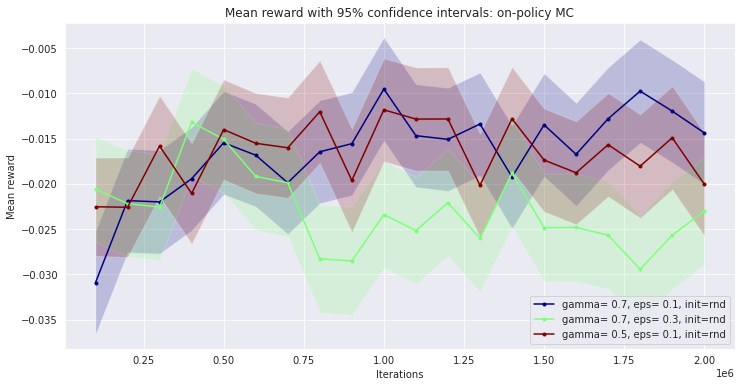

In [ ]:
plot_runs(runs2)

Getting better, but still our agent can't win.

In [ ]:
env.close()

## Часть третья, в главной роли — Дастин Хоффман

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. 

In [ ]:
class BlackjackEnvDoubleCount(BlackjackEnv):
    def __init__(self, natural, seed):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), 
             spaces.Discrete(2), spaces.Discrete(41))
        )
        self.seed(seed)
        self.start_deck()
        self.reset()
        self.natural = natural


    def _get_obs(self):
      return (sum_hand(self.player), self.dealer[0], 
              usable_ace(self.player), self.count)
      

    @staticmethod
    def get_value(card):
      if card in [1, 10]:
        return -1
      elif card in range(2, 7):
        return 1

      return 0


    def start_deck(self):
      self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
      rng.shuffle(self.deck)
      self.count = 0


    def draw_card(self, visible=True):
      if len(self.deck) < 15:
         self.start_deck()

      card = self.deck.pop()
      if visible:
        self.count += self.__class__.get_value(card)

      return card
      

    def reset(self):
      self.player = [self.draw_card(), self.draw_card()]
      self.dealer = [self.draw_card(), self.draw_card(False)]
      self.hidden_dealer_cards_start_index = 1

      return self._get_obs()


    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2: # double: add card to players hand and double reward/loss
            self.player.append(self.draw_card())
            done = True

            if is_bust(self.player):
                reward = -2.0
            else:
              while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(False))

              reward = 2 * blackjack_cmp(score(self.player), score(self.dealer))
              if (self.natural 
                  and is_natural(self.player) 
                  and reward == 2
                  ):
                reward = 3    
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(False))

            reward = blackjack_cmp(score(self.player), score(self.dealer))
            if (self.natural
                and is_natural(self.player)
                and reward == 1.0
                ):
                reward = 1.5

        if done:
          for card in self.dealer[self.hidden_dealer_cards_start_index:]:
            self.count += self.__class__.get_value(card)

        return self._get_obs(), reward, done, {}

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Modifying again initialization, taking into account another dimension of states.

In [ ]:
def initialize_Q(env, random=True):
  if random:
    Q = defaultdict(lambda: rng.random(env.action_space.n))
  else:
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
  for player in range(32):
    for dealer in range(11):
      for ace in range(2):
        for count in range(-20, 21, 1):
          if player > 21:
            Q[(player, dealer, ace, count)] = -1 * np.ones(env.action_space.n)
            Q[(player, dealer, ace, count)][2] = -2
          elif player == 21:
            Q[(player, dealer, ace, count)] = np.ones(env.action_space.n)
            Q[(player, dealer, ace, count)][2] = 2

  return Q

Again, looking across a few parameters and training for longer...

In [ ]:
runs3 = {}
env = BlackjackEnvDoubleCount(natural=True, seed=seed)

In [ ]:
eps = .1
gamma = .7
result = train_MC(env, eps=eps, gamma=gamma, total_episodes=10_000_000, 
                  print_every_n_eps=400_000, eval_every_n_eps=200_000, 
                  policy_run_episodes=250_000)
runs3[f"{seed}, {eps}, {gamma}"] = result

#########Training policy#########


  4%|▍         | 401896/10000000 [00:41<2:21:46, 1128.37it/s]

|| Mean reward: -0.051434 


  8%|▊         | 801607/10000000 [01:23<2:09:40, 1182.24it/s]

|| Mean reward: -0.037122 


 12%|█▏        | 1201571/10000000 [02:06<2:03:43, 1185.22it/s]

|| Mean reward: -0.032592 


 16%|█▌        | 1601347/10000000 [02:49<2:01:24, 1152.95it/s]

|| Mean reward: -0.022116 


 20%|██        | 2002049/10000000 [03:32<1:55:31, 1153.90it/s]

|| Mean reward: -0.01823 


 24%|██▍       | 2402084/10000000 [04:14<1:49:47, 1153.33it/s]

|| Mean reward: -0.016628 


 28%|██▊       | 2801875/10000000 [04:57<1:46:11, 1129.80it/s]

|| Mean reward: -0.01449 


 32%|███▏      | 3201818/10000000 [05:40<1:37:45, 1159.06it/s]

|| Mean reward: -0.011354 


 36%|███▌      | 3601409/10000000 [06:23<1:31:17, 1168.26it/s]

|| Mean reward: -0.017398 


 40%|████      | 4001512/10000000 [07:05<1:23:17, 1200.38it/s]

|| Mean reward: -0.009364 


 44%|████▍     | 4401664/10000000 [07:48<1:18:44, 1184.95it/s]

|| Mean reward: -0.015326 


 48%|████▊     | 4801575/10000000 [08:31<1:14:25, 1164.15it/s]

|| Mean reward: -0.011942 


 52%|█████▏    | 5202141/10000000 [09:14<1:10:00, 1142.12it/s]

|| Mean reward: -0.01041 


 56%|█████▌    | 5601893/10000000 [09:57<1:03:19, 1157.50it/s]

|| Mean reward: -0.010194 


 60%|██████    | 6001773/10000000 [10:40<57:41, 1155.21it/s] 

|| Mean reward: -0.010346 


 64%|██████▍   | 6401778/10000000 [11:23<51:04, 1173.99it/s] 

|| Mean reward: -0.009766 


 68%|██████▊   | 6801181/10000000 [12:05<1:03:22, 841.25it/s]

|| Mean reward: -0.011258 


 72%|███████▏  | 7201797/10000000 [12:48<40:05, 1163.39it/s]

|| Mean reward: -0.013262 


 76%|███████▌  | 7602118/10000000 [13:31<34:59, 1142.05it/s]

|| Mean reward: -0.010786 


 80%|████████  | 8001633/10000000 [14:14<30:23, 1096.07it/s]

|| Mean reward: -0.011194 


 84%|████████▍ | 8401780/10000000 [14:57<23:29, 1133.98it/s]

|| Mean reward: -0.01224 


 88%|████████▊ | 8801381/10000000 [15:39<16:58, 1176.91it/s]

|| Mean reward: -0.009052 


 92%|█████████▏| 9201916/10000000 [16:22<11:21, 1170.52it/s]

|| Mean reward: -0.010634 


 96%|█████████▌| 9601486/10000000 [17:05<05:46, 1149.87it/s]

|| Mean reward: -0.012142 


100%|██████████| 10000000/10000000 [17:47<00:00, 9363.74it/s]

|| Mean reward: -0.00721 


In [ ]:
eps = .1
gamma = .7
random_Q = False
result = train_MC(env, eps=eps, gamma=gamma, total_episodes=10_000_000, 
                  print_every_n_eps=400_000, eval_every_n_eps=200_000, 
                  policy_run_episodes=250_000, random_Q=random_Q)
if not random_Q:
  runs3[f"{seed}, {eps}, {gamma}, zero"] = result
else:
  runs3[f"{seed}, {eps}, {gamma}"] = result

#########Training policy#########


  4%|▍         | 401272/10000000 [00:42<2:17:38, 1162.26it/s]

|| Mean reward: -0.042732 


  8%|▊         | 801847/10000000 [01:24<2:12:14, 1159.30it/s]

|| Mean reward: -0.029246 


 12%|█▏        | 1202294/10000000 [02:07<2:05:51, 1165.09it/s]

|| Mean reward: -0.023266 


 16%|█▌        | 1602436/10000000 [02:50<1:57:54, 1187.10it/s]

|| Mean reward: -0.025774 


 20%|██        | 2001462/10000000 [03:32<1:53:31, 1174.27it/s]

|| Mean reward: -0.01601 


 24%|██▍       | 2401554/10000000 [04:15<1:49:04, 1161.04it/s]

|| Mean reward: -0.015092 


 28%|██▊       | 2801395/10000000 [04:58<1:46:28, 1126.83it/s]

|| Mean reward: -0.014066 


 32%|███▏      | 3201513/10000000 [05:41<1:42:26, 1106.01it/s]

|| Mean reward: -0.012398 


 36%|███▌      | 3601491/10000000 [06:24<1:35:32, 1116.26it/s]

|| Mean reward: -0.018276 


 40%|████      | 4002301/10000000 [07:07<1:27:37, 1140.85it/s]

|| Mean reward: -0.013704 


 44%|████▍     | 4402131/10000000 [07:49<1:22:40, 1128.53it/s]

|| Mean reward: -0.012004 


 48%|████▊     | 4801493/10000000 [08:32<1:14:59, 1155.27it/s]

|| Mean reward: -0.013644 


 52%|█████▏    | 5201891/10000000 [09:15<1:08:38, 1165.01it/s]

|| Mean reward: -0.012552 


 56%|█████▌    | 5602107/10000000 [09:58<1:03:32, 1153.44it/s]

|| Mean reward: -0.015236 


 60%|██████    | 6001855/10000000 [10:41<57:10, 1165.35it/s] 

|| Mean reward: -0.012262 


 64%|██████▍   | 6401168/10000000 [11:24<55:44, 1076.15it/s] 

|| Mean reward: -0.012652 


 68%|██████▊   | 6801992/10000000 [12:07<45:28, 1172.02it/s] 

|| Mean reward: -0.007072 


 72%|███████▏  | 7201968/10000000 [12:49<40:32, 1150.25it/s]

|| Mean reward: -0.014564 


 76%|███████▌  | 7602244/10000000 [13:32<34:53, 1145.35it/s]

|| Mean reward: -0.00984 


 80%|████████  | 8001922/10000000 [14:16<29:11, 1140.81it/s]

|| Mean reward: -0.008122 


 84%|████████▍ | 8401338/10000000 [14:58<24:03, 1107.29it/s]

|| Mean reward: -0.002704 


 88%|████████▊ | 8801550/10000000 [15:41<17:52, 1117.80it/s]

|| Mean reward: -0.010942 


 92%|█████████▏| 9201243/10000000 [16:24<11:15, 1182.21it/s]

|| Mean reward: -0.009106 


 96%|█████████▌| 9601947/10000000 [17:07<05:45, 1153.45it/s]

|| Mean reward: -0.009978 


100%|██████████| 10000000/10000000 [17:50<00:00, 9341.40it/s]

|| Mean reward: -0.008794 


In [ ]:
eps = .1
gamma = .5
random_Q = False
result = train_MC(env, eps=eps, gamma=gamma, total_episodes=10_000_000, 
                  print_every_n_eps=400_000, eval_every_n_eps=200_000, 
                  policy_run_episodes=250_000, random_Q=random_Q)
if not random_Q:
  runs3[f"{seed}, {eps}, {gamma}, zero"] = result
else:
  runs3[f"{seed}, {eps}, {gamma}"] = result

#########Training policy#########


  4%|▍         | 401960/10000000 [00:43<2:26:09, 1094.42it/s]

|| Mean reward: -0.039466 


  8%|▊         | 801885/10000000 [01:26<2:14:17, 1141.54it/s]

|| Mean reward: -0.02563 


 12%|█▏        | 1201459/10000000 [02:09<2:08:44, 1139.05it/s]

|| Mean reward: -0.028946 


 16%|█▌        | 1602057/10000000 [02:52<2:00:06, 1165.26it/s]

|| Mean reward: -0.019078 


 20%|██        | 2001657/10000000 [03:35<1:55:27, 1154.57it/s]

|| Mean reward: -0.01309 


 24%|██▍       | 2401612/10000000 [04:18<1:53:03, 1120.07it/s]

|| Mean reward: -0.013932 


 28%|██▊       | 2801949/10000000 [05:01<1:49:33, 1095.08it/s]

|| Mean reward: -0.012184 


 32%|███▏      | 3201836/10000000 [05:44<1:38:02, 1155.63it/s]

|| Mean reward: -0.012538 


 36%|███▌      | 3601507/10000000 [06:27<1:40:42, 1058.96it/s]

|| Mean reward: -0.018848 


 40%|████      | 4001186/10000000 [07:10<1:28:18, 1132.10it/s]

|| Mean reward: -0.00984 


 44%|████▍     | 4401481/10000000 [07:53<1:29:19, 1044.64it/s]

|| Mean reward: -0.0114 


 48%|████▊     | 4801462/10000000 [08:36<1:16:03, 1139.12it/s]

|| Mean reward: -0.010948 


 52%|█████▏    | 5201936/10000000 [09:19<1:09:34, 1149.50it/s]

|| Mean reward: -0.010706 


 56%|█████▌    | 5601973/10000000 [10:02<1:02:49, 1166.82it/s]

|| Mean reward: -0.007442 


 60%|██████    | 6001579/10000000 [10:45<57:44, 1154.22it/s] 

|| Mean reward: -0.012368 


 64%|██████▍   | 6401358/10000000 [11:28<51:57, 1154.33it/s] 

|| Mean reward: -0.008414 


 68%|██████▊   | 6802417/10000000 [12:10<44:06, 1208.09it/s] 

|| Mean reward: -0.008144 


 72%|███████▏  | 7201222/10000000 [12:52<41:31, 1123.11it/s]

|| Mean reward: -0.007008 


 76%|███████▌  | 7601492/10000000 [13:34<33:56, 1177.76it/s]

|| Mean reward: -0.010894 


 80%|████████  | 8001964/10000000 [14:16<29:17, 1136.63it/s]

|| Mean reward: -0.012118 


 84%|████████▍ | 8402427/10000000 [14:58<22:26, 1186.90it/s]

|| Mean reward: -0.01286 


 88%|████████▊ | 8802079/10000000 [15:41<17:23, 1147.54it/s]

|| Mean reward: -0.003062 


 90%|█████████ | 9025794/10000000 [16:04<01:20, 12048.33it/s]

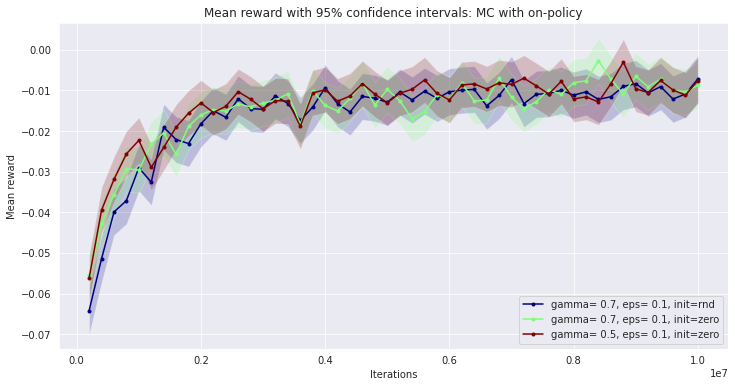

In [ ]:
plot_runs(runs3)

And mean of rewards, std and episode number for one of the runs...

In [ ]:
runs3['1, 0.1, 0.5, zero']['rewards']

[[-0.056168, 1.1277921598308793, 199999],
 [-0.039466, 1.113928828446414, 399999],
 [-0.031904, 1.1083186070728939, 599999],
 [-0.02563, 1.1122617062094695, 799999],
 [-0.02232, 1.1156459194565271, 999999],
 [-0.028946, 1.1158929738482986, 1199999],
 [-0.024048, 1.1110165136918533, 1399999],
 [-0.019078, 1.1065518649914245, 1599999],
 [-0.015634, 1.1057244584633188, 1799999],
 [-0.01309, 1.1051821804118993, 1999999],
 [-0.015456, 1.109361578595545, 2199999],
 [-0.013932, 1.110852780244079, 2399999],
 [-0.01034, 1.1102148820836444, 2599999],
 [-0.012184, 1.1101295195354461, 2799999],
 [-0.014544, 1.1086299978189296, 2999999],
 [-0.012538, 1.1074049839855333, 3199999],
 [-0.012648, 1.1088715110850311, 3399999],
 [-0.018848, 1.1058791764456009, 3599999],
 [-0.01064, 1.1071570757575457, 3799999],
 [-0.00984, 1.1075383399232732, 3999999],
 [-0.01268, 1.1089117266942394, 4199999],
 [-0.0114, 1.1079539882143121, 4399999],
 [-0.008354, 1.1078281503392122, 4599999],
 [-0.010948, 1.1095774607011

That's probably as good as it can get. Will leave playing with splitting for ano